In [1]:
!pip install pygame pyvirtualdisplay

In [2]:
!apt install swig && pip install gymnasium box2d box2d-kengz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 2s (734 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 126319 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubunt

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, HTML
import base64
import os

In [4]:
env = gym.make("Acrobot-v1", render_mode="rgb_array")
print(env.observation_space)
print(env.action_space)

Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
Discrete(3)


In [5]:
env.observation_space.shape

(6,)

In [6]:
obs_space_low_ar = env.observation_space.low
obs_space_high_ar = env.observation_space.high
arrays = []
for i in range(len(obs_space_low_ar)):
    arrays.append([obs_space_low_ar[i], obs_space_high_ar[i]])
obs_bounds = np.array(arrays)
print(obs_bounds)


[[ -1.         1.      ]
 [ -1.         1.      ]
 [ -1.         1.      ]
 [ -1.         1.      ]
 [-12.566371  12.566371]
 [-28.274334  28.274334]]


The action space is discrete with actions taking on values of 0 or 1 or 2. The observation space is a continuous but bounded space in R^6. Since this notebook is an implementation of tabular Q-Learning, we want to have a matrix of states x actions to hold the state-action value estimates. So, we need to discretize the observation space. The first 2 elements of a state define the angle of the first joint. The next 2 elements define the angle of the actuated joint (ie: joint connecting the 2 links). The final 2 elements define the velocity of each joint.

We can discretize the observation space by having 10 intervals for each of the first 4 dimensions and 20 intervals for the last 2 dimensions. So, we have 10^4 * 20^2 = 4,000,000 states

In [8]:
import bisect

dim1_intervals = np.linspace(obs_bounds[0][0], obs_bounds[0][1], 11)[:10] #get the left bounds fo each of the 10 intervals for dim 1
dim2_intervals = np.linspace(obs_bounds[1][0], obs_bounds[1][1], 11)[:10] #get the left bounds of each of the 10 intervals for dim 2
dim3_intervals = np.linspace(obs_bounds[2][0], obs_bounds[2][1], 11)[:10] #get the left bounds fo each of the 10 intervals for dim 3
dim4_intervals = np.linspace(obs_bounds[3][0], obs_bounds[3][1], 11)[:10] #get the left bounds of each of the 10 intervals for dim 4
dim5_intervals = np.linspace(obs_bounds[4][0], obs_bounds[4][1], 21)[:20] #get the left bounds fo each of the 20 intervals for dim 5
dim6_intervals = np.linspace(obs_bounds[5][0], obs_bounds[5][1], 21)[:20] #get the left bounds of each of the 20 intervals for dim 6


def get_dim1_interval_idx(val):
    # returns the index in the discretized version of dim 1 that the current obs belongs to
    if val in dim1_intervals:
        return bisect.bisect_left(dim1_intervals, val)
    return bisect.bisect_left(dim1_intervals, val) - 1


def get_dim2_interval(val):
  # returns the index in the discretized version of dim 2 that the current obs belongs to
  if val in dim2_intervals:
        return bisect.bisect_left(dim2_intervals, val)
  return bisect.bisect_left(dim2_intervals, val) - 1


def get_dim3_interval_idx(val):
    # returns the index in the discretized version of dim 3 that the current obs belongs to
    if val in dim3_intervals:
        return bisect.bisect_left(dim3_intervals, val)
    return bisect.bisect_left(dim3_intervals, val) - 1


def get_dim4_interval(val):
  # returns the index in the discretized version of dim 4 that the current obs belongs to
  if val in dim4_intervals:
        return bisect.bisect_left(dim4_intervals, val)
  return bisect.bisect_left(dim4_intervals, val) - 1


def get_dim5_interval_idx(val):
    # returns the index in the discretized version of dim 5 that the current obs belongs to
    if val in dim5_intervals:
        return bisect.bisect_left(dim5_intervals, val)
    return bisect.bisect_left(dim5_intervals, val) - 1


def get_dim6_interval(val):
  # returns the index in the discretized version of dim 6 that the current obs belongs to
  if val in dim6_intervals:
        return bisect.bisect_left(dim6_intervals, val)
  return bisect.bisect_left(dim6_intervals, val) - 1

def convert_obs_to_state_idx(obs):
  return [get_dim1_interval_idx(obs[0]), get_dim2_interval(obs[1]), get_dim3_interval_idx(obs[2]), get_dim4_interval(obs[3]), get_dim5_interval_idx(obs[4]), get_dim6_interval(obs[5])]



In [10]:
num_actions = env.action_space.n
Q = np.random.normal(size=(10, 10, 10, 10, 20, 20, num_actions))
alpha = .05 #implies that each update to a state-action value pair is 95% of the current value and 5% of the new value
gamma = .99 #discount factor on future rewards
num_episodes = 15000
epsilon = .35

In [11]:
for episode_idx in range(num_episodes):
  reward_sum = 0
  next_obs, _ = env.reset() #reset the env to get initial state


  done = False
  while not done:
      obs = next_obs

      #choose action in an epsilon greedy manner
      if np.random.random() <= epsilon:
        action = env.action_space.sample()
      else:
        action = np.argmax(Q[tuple(convert_obs_to_state_idx(obs) + [slice(None)])])


      next_obs, reward, terminated, truncated, _ = env.step(action)
      reward_sum += reward

      done = terminated or truncated

      if not done:
        #update Q with state-action value estimate
        Q[tuple(convert_obs_to_state_idx(obs) + [action])] += alpha * (reward + gamma * np.max(Q[tuple(convert_obs_to_state_idx(next_obs) + [slice(None)])]) - Q[tuple(convert_obs_to_state_idx(obs) + [action])])
      else:
        Q[tuple(convert_obs_to_state_idx(obs) + [action])] += alpha * (reward - Q[tuple(convert_obs_to_state_idx(obs) + [action])])

        if episode_idx % 100 == 0:
          print(episode_idx, reward_sum, sep=': ')


env.close()


0: -500.0
100: -500.0
200: -500.0
300: -500.0
400: -500.0
500: -364.0
600: -500.0
700: -500.0
800: -429.0
900: -500.0
1000: -500.0
1100: -500.0
1200: -415.0
1300: -500.0
1400: -210.0
1500: -500.0
1600: -361.0
1700: -371.0
1800: -500.0
1900: -221.0
2000: -352.0
2100: -424.0
2200: -500.0
2300: -206.0
2400: -410.0
2500: -428.0
2600: -242.0
2700: -500.0
2800: -231.0
2900: -500.0
3000: -500.0
3100: -500.0
3200: -500.0
3300: -291.0
3400: -273.0
3500: -254.0
3600: -395.0
3700: -500.0
3800: -420.0
3900: -500.0
4000: -211.0
4100: -303.0
4200: -464.0
4300: -297.0
4400: -298.0
4500: -281.0
4600: -500.0
4700: -292.0
4800: -300.0
4900: -500.0
5000: -392.0
5100: -290.0
5200: -251.0
5300: -226.0
5400: -500.0
5500: -180.0
5600: -389.0
5700: -306.0
5800: -388.0
5900: -221.0
6000: -222.0
6100: -423.0
6200: -252.0
6300: -225.0
6400: -283.0
6500: -218.0
6600: -497.0
6700: -500.0
6800: -433.0
6900: -257.0
7000: -500.0
7100: -370.0
7200: -315.0
7300: -226.0
7400: -208.0
7500: -282.0
7600: -500.0
7700: -237.

-153.0


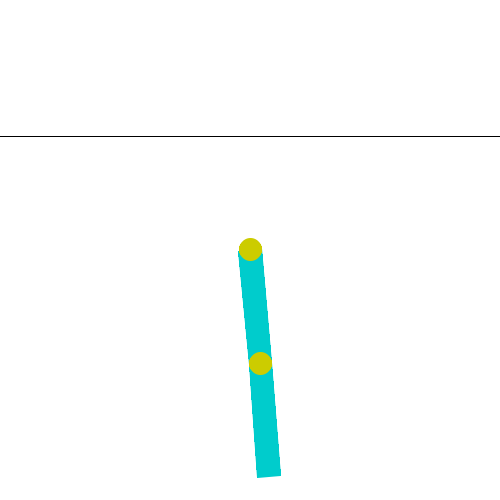

In [12]:
reward_sum = 0
frames = []
next_obs, _ = env.reset() #reset the env to get initial state


done = False

while not done:
    frame = env.render()
    frames.append(Image.fromarray(frame))
    obs = next_obs
    #choose action in a greedy manner
    action = np.argmax(Q[tuple(convert_obs_to_state_idx(obs) + [slice(None)])])


    next_obs, reward, terminated, truncated, _ = env.step(action)
    reward_sum += reward

    done = terminated or truncated

env.close()
print(reward_sum)
# Save to GIF
frames[0].save("acrobot.gif", save_all=True, append_images=frames[1:], duration=50, loop=0)

# Display the GIF in notebook
from IPython.display import Image as IPyImage
IPyImage(filename="acrobot.gif")